# Test Functional Coherence of GO Terms in Clusters

In [22]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import jaccard
from scipy.stats import ttest_ind
from tqdm import tqdm

from philharmonic.utils import (
    add_GO_function,
    clean_top_terms,
    load_cluster_json,
    parse_GO_database,
    parse_GO_map,
)

In [23]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"

GO_SLIM = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/goslim_generic.obo"

from pathlib import Path
IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img")

---

## Load Files

In [24]:
# Load clusters
cluster_dict = load_cluster_json(cluster_file_path)

In [25]:
# Add GO Annotations
go_map = parse_GO_map(go_map_path)
go_db = parse_GO_database(GO_SLIM)

In [26]:
for clust in cluster_dict.values():
    clust["GO_terms"] = add_GO_function(clust, go_map, go_db=go_db)
    for gt in clust["GO_terms"].keys():
        assert gt in go_db.keys()

---

## Native Cluster Coherence

In [27]:
def protein_GO_bit_vector(
    protein_id, go_map, full_go_list, id_col="seq", go_col="GO_ids"
):
    go_bv = np.zeros(len(full_go_list))
    prot_go = go_map.get(protein_id)
    if prot_go is not None:
        for gid in prot_go:
            if gid in full_go_list:
                go_bv[full_go_list.index(gid)] = 1
    return go_bv

In [28]:
go_assigned = set()
for clust in tqdm(cluster_dict.values()):
    for g in clust["GO_terms"].keys():
        go_assigned.add(g)
go_assigned = sorted(list(go_assigned))
len(go_assigned)

100%|██████████| 468/468 [00:00<00:00, 290117.39it/s]


48

In [29]:
proteins_in_clusters = []
for clust in tqdm(cluster_dict.values()):
    proteins_in_clusters.extend(clust["members"])

100%|██████████| 468/468 [00:00<00:00, 748354.66it/s]


In [30]:
len(proteins_in_clusters)

7193

In [31]:
protein_GO_bvs = {}
for pid in proteins_in_clusters:
    protein_GO_bvs[pid] = protein_GO_bit_vector(pid, go_map, go_assigned)

cluster_jaccards = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(clust["members"], 2):
        jc = 1 - jaccard(protein_GO_bvs[p1], protein_GO_bvs[p2])
        cjaccard.append(jc)
    cluster_jaccards[k] = np.array(cjaccard)

100%|██████████| 468/468 [00:00<00:00, 1128.68it/s]


---

## Shuffled Cluster Coherence

In [32]:
rng = np.random.default_rng(seed=42)
shuffled_keys = rng.permutation(list(go_map.keys()))
shuffled_go_map = {k: v for k, v in zip(shuffled_keys, go_map.values())}

In [33]:
protein_GO_bvs_perm = {}
for pid in proteins_in_clusters:
    protein_GO_bvs_perm[pid] = protein_GO_bit_vector(pid, shuffled_go_map, go_assigned)

cluster_jaccards_perm = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(clust["members"], 2):
        jc = 1 - jaccard(protein_GO_bvs_perm[p1], protein_GO_bvs_perm[p2])
        cjaccard.append(jc)
    cluster_jaccards_perm[k] = np.array(cjaccard)

100%|██████████| 468/468 [00:00<00:00, 1098.83it/s]


--- 


## Compare shuffled and original coherence

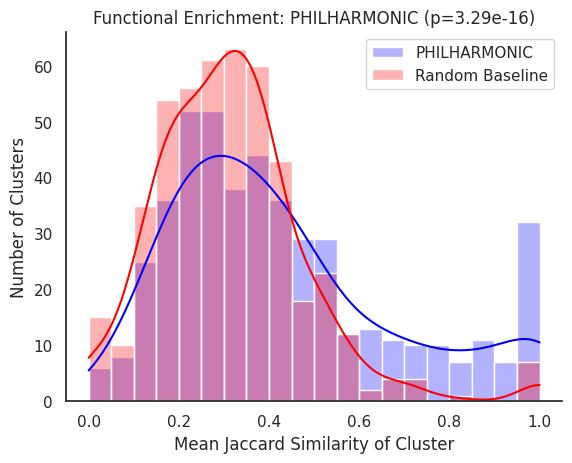

In [37]:
sns.set_palette("colorblind")
sns.set_theme(style="white", font_scale=1)
kde = True

phil_mean = [i.mean() for i in cluster_jaccards.values()]
permute_mean = [i.mean() for i in cluster_jaccards_perm.values()]

sns.histplot(
    phil_mean,
    color="blue",
    label="PHILHARMONIC",
    bins=np.arange(0, 1.05, 0.05),
    alpha=0.3,
    kde=kde,
)
sns.histplot(
    permute_mean,
    color="red",
    label="Random Baseline",
    bins=np.arange(0, 1.05, 0.05),
    alpha=0.3,
    kde=kde,
)
tstat, p = ttest_ind(phil_mean, permute_mean, alternative="greater")

plt.title("Functional Enrichment: PHILHARMONIC (p={:.3})".format(p))
plt.xlabel("Mean Jaccard Similarity of Cluster")
plt.ylabel("Number of Clusters")
plt.legend()
sns.despine()
plt.savefig("../img/readme_function_enrichment.png", bbox_inches="tight", dpi=300)
plt.savefig(IMG_DIR / "pdam_function_enrichment.svg", bbox_inches="tight", dpi=300)
plt.show()

---
## Display Coherence by GO Slim Function

In [38]:
cluster_top_terms = {
    k: clean_top_terms(clust, go_db, return_counts=False)
    for k, clust in cluster_dict.items()
}

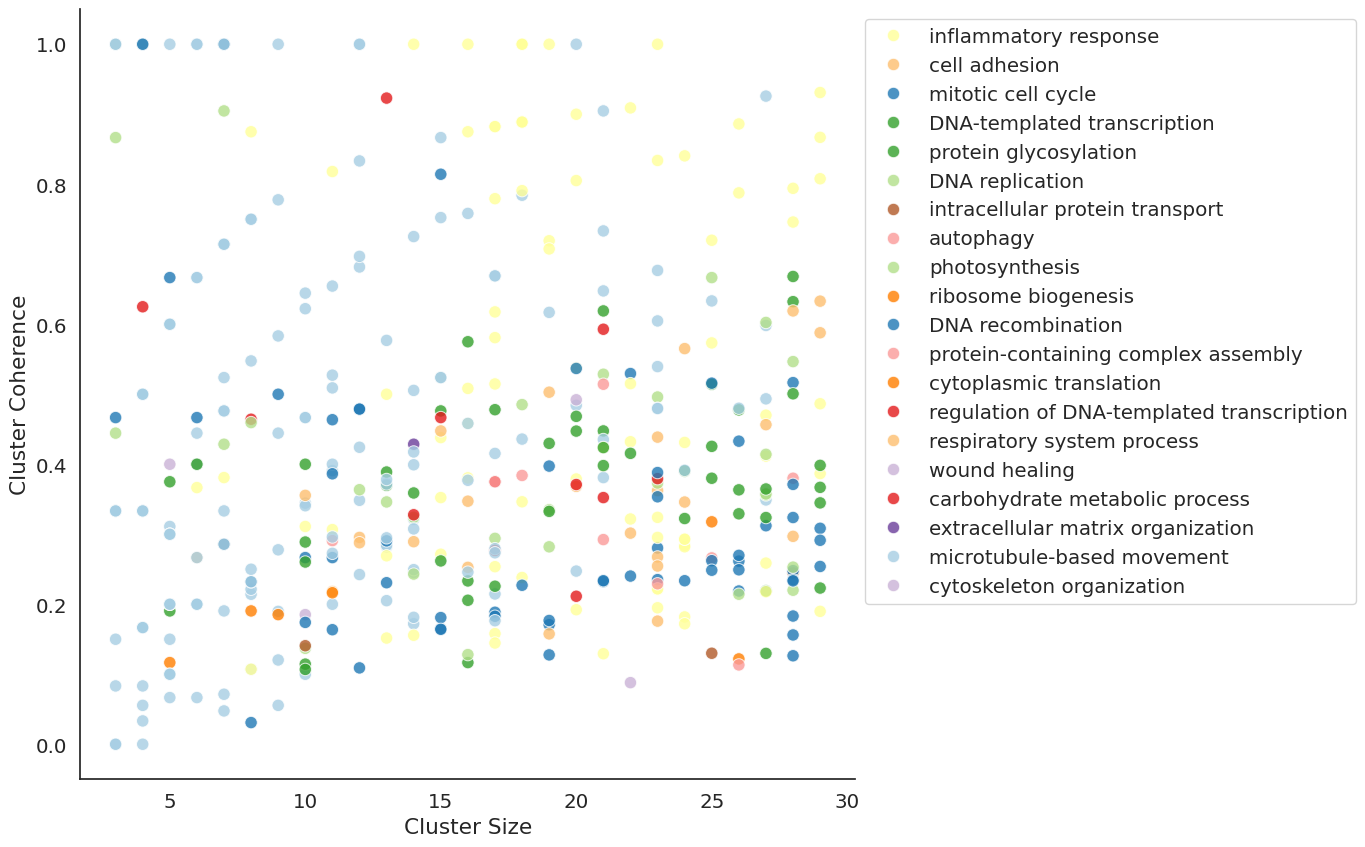

In [39]:
sns.set_theme(style="white", font_scale=1.3)
fig, ax = plt.subplots(figsize=(10, 10))

clens = [len(clust["members"]) for clust in cluster_dict.values()]
cjacc = [np.mean(cluster_jaccards[k]) for k in cluster_dict]
cfunc = [cluster_top_terms[k] for k in cluster_dict]
color_map = {
    k: v
    for k, v in zip(sorted(set(cfunc)), sns.color_palette("Paired", len(set(cfunc))))
}
color_map["No function"] = (0.8, 0.8, 0.8)

sns.scatterplot(x=clens, y=cjacc, s=80, alpha=0.8, hue=cfunc, palette=color_map, ax=ax)
plt.xlabel("Cluster Size")
plt.ylabel("Cluster Coherence")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.savefig(IMG_DIR / "pdam_enrichment_by_function.svg", bbox_inches="tight", dpi=300)
plt.show()